In [1]:
#!pip install statannotations

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
#3from statannotations.Annotator import Annotator #https://github.com/trevismd/statannotations

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# if getting OptionError: "No such keys(s): 'mode.use_inf_as_null'"
# !pip install --upgrade seaborn pandas

import matplotlib as mpl
import os
from glob import glob

from _load_data import * # Getting our specific labels, formatting, and data

# Getting some free samples
results_df.sample(3)

print(gens)

# Don't change any code below, it may break (probably will) --------------------

['../models/SimplifierBottomUp.py', '../models/SimplifierBottomUpOnlyLast.py', '../models/SimplifierTopDown.py', '../models/Vanilla.py', '../models/SimplifierTopDownOnlyLast.py'] ['Bottom Up', 'Bottom Up (only last)', 'Top Down', 'Without simplify', 'Top Down (only last)']
(750, 14)
['Bottom Up' 'Bottom Up (only last)' 'Top Down' 'Without simplify'
 'Top Down (only last)']
['Airfoil' 'Concrete' 'Energy Cooling' 'Energy Heating' 'Housing']
[10, 20, 30, 40, 50, 60, 70, 80, 90, 99]


In [2]:
from sympy import *
import re

func_dict = {
   'multiply': '*',
   'subtract': '-',
   'add3': '+',
   'add4': '+',
   'mul3': '*',
   'mul4': '*',
   'cdiv': '/',
   'add': '+'
}

func_arity = {
   'multiply': 2,
   'subtract': 2,
   'add3': 3,
   'add4': 4,
   'mul3': 3,
   'mul4': 4,
   'cdiv': 2,
   'add': 2,
    'maximum' : 2,
    'minimum' : 2,
    'max' : 2,
    'min' : 2,
    'sin' : 1,
    'cos' : 1,
    'tan' : 1,
    'sqrtabs' : 1,
    'sqrt' : 1,
    'abs' : 1,
    'log1p'   : 1,
    'exp'     : 1,
    'square'  : 1,
    'absolute'     : 1
}

def pretify_expr(string):
    # Breaking down into a list of symbols. handliilng sqrtabs and max/minimum
    ind = string.replace('sqrtabs','sqrt').replace('imum','') \
                .replace(' ','').replace(')','').replace('(',',').split(',')

    new_string = ""
    stack = []
    for node in ind:
        stack.append((node, []))
        while len(stack[-1][1]) == func_arity.get(stack[-1][0], 0):

            prim, args = stack.pop()
            new_string = prim
            if prim in func_dict.keys():
                new_string = '(' + func_dict[prim].join(args) + ')'
            elif not prim.startswith('x_'):
                try:
                    float(prim)
                except:
                    new_string = prim + '(' + args[0] + ')'
                
            if len(stack) == 0:
                break

            stack[-1][1].append(new_string)

    return new_string

def count_float_occurrences(s):
   pattern = r'\d+\.\d+' # Matches sequences of digits followed by a dot and more digits
   matches = re.findall(pattern, s)
   return len(matches)

def count_occurrences(s, sub):
   res = 0
   for i in range(len(s)):
       if s[i:i+len(sub)] == sub:
           res += 1
   return res

funcs = [
'-', '+', '+', '/', 'maximum', 'minimum', 'max', 'min', 'sin', 'cos', 'tan', 'sqrtabs', 
'sqrt', 'abs', 'log1p', 'exp', 'square', 'absolute']

In [3]:
new_columns = []

for i, col in results_df.iterrows():
    sympy_compatible = str(pretify_expr(col['representation']))
    sympy_simplified = str(simplify(sympy_compatible))

    # stats: number of functions, constants, variables, and total number ofnodes
    n_features_before  = count_occurrences(sympy_compatible, "x_")
    n_constants_before = count_float_occurrences(sympy_compatible)
    n_functions_before = sum([count_occurrences(sympy_compatible, f)
                              for f in funcs])

    n_features_after  = count_occurrences(sympy_simplified, "x_")
    n_constants_after = count_float_occurrences(sympy_simplified)
    n_functions_after = sum([count_occurrences(sympy_simplified, f)
                             for f in funcs])

    new_columns.append([
        n_features_before-n_features_after,
        n_constants_before-n_constants_after,
        n_functions_before-n_functions_after,
        (n_features_before+n_constants_before+n_functions_before)-\
        (n_features_after+n_constants_after+n_functions_after),
    ])

deltas_df = pd.DataFrame(new_columns, columns=['features simplified',
                                               'constants simplified',
                                               'functions simplified',
                                               'nodes simplified'])

results_df = pd.concat([results_df, deltas_df], axis=1 )
results_df.sample(3)

,model,dataset,RunID,random_state,time,date,train_r2,test_r2,train_mse,test_mse,representation,size,complexity,depth,features simplified,constants simplified,functions simplified,nodes simplified
143,Top Down (only last),Airfoil,0,10132,485.664653,01-17-2024 02:11:03,0.399040,0.396063,18.351649,17.670440,"square(add(10.416955591901116, cdiv(20896.789530932496, add(mul4(x_0, x_4, add3(x_2, x_4, x_4), x_0), 21822.59736738491))))",15,1668,6,2,0,2,4
485,Bottom Up (only last),Energy Heating,0,4866,504.333667,01-17-2024 05:11:55,0.922518,0.919944,7.375858,7.579499,"multiply(multiply(add3(-2.2360541825337137, x_4, sqrtabs(multiply(12.166366214787038, x_6))), subtract(sqrtabs(x_2), 6.0605789031895725)), 0.4080410785172067)",14,68,5,0,0,2,2
42,Bottom Up (only last),Airfoil,0,16695,672.517011,01-16-2024 15:38:32,0.241435,-0.012835,19.839465,25.387870,"add3(square(add(4.886204283232651, mul4(log1p(x_4), x_0, -0.18772988221732884, x_2))), x_4, 104.94589707492419)",12,2652,5,0,0,0,0


[[<Axes: ylabel='features simplified'>]]


NameError: name 'Annotator' is not defined

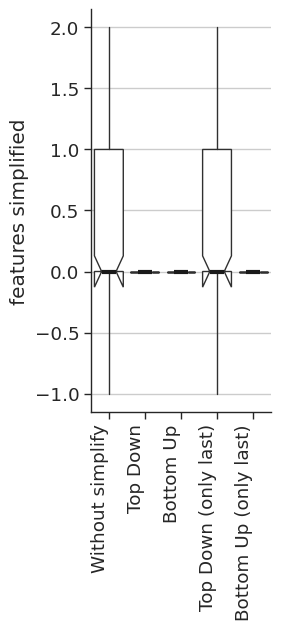

In [4]:
for yaxis in deltas_df.columns:
    g=sns.catplot( data=results_df, y=yaxis, x='model', 
        legend_out=False, aspect=0.75,
        order = order, # The first is Baseline
        **{**boxplot_kwargs, **{'showfliers':False}}, sharey=False
    )

    # g.set(yscale="log")
    g.set_titles("{col_name}").set_axis_labels("", yaxis)

    print(g.axes)

    # iterate through each subplot / Facet
    plot_ax = g.axes[0, 0]

    plot_ax.grid(which='major', axis='y', linewidth=1)

    for tick in plot_ax.get_xticklabels():
        tick.set(rotation=90, ha="right")

    if True:
        # All vs baseline
        pairs = [('Without simplify', l)
                    for l in results_df['model'].unique()
                    if l != 'Without simplify']

        annotator = Annotator(
            plot_ax, pairs, data=results_df,
            x='model', y=yaxis,
            order=order)
        annotator.reset_configuration()
        annotator.configure(test="Mann-Whitney", hide_non_significant=True, #text_format='full',
                                comparisons_correction="holm", verbose=1, text_offset=-3)
        annotator.apply_and_annotate()

    plt.tight_layout()
    plt.savefig(f"../paper/figs/{yaxis}_boxplot.pdf")
    plt.savefig(f"../paper/figs/{yaxis}_boxplot.png")
    plt.show()